# PCA on original data

In [1]:
import pandas as pd
import numpy as np

from sklearn.cross_validation import StratifiedShuffleSplit

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# read original data from train.csv. This data set is taken from a real Kaggle competition 
orig_data = pd.read_table('train.csv', sep=',', header=0)

In [3]:
# separate label information from features and drop the ID as it is not relevant for future training purposes.
# according to the data description in the competition, the label's values are 0=satisfied and 1=unsatisified customer
labels = orig_data['TARGET']
features = orig_data.drop(['ID', 'TARGET'], axis=1)

In [4]:
# split the original data set into an X_train and an X_valid set and respective labels Y_train and Y_valid.
# on the X_train set a classifier will be trained and on the X_valid set it will be applied for predictions. 

# stratfiedShuffleSplit used: to keep the ratio of 0s and 1s in your train and valid sets, so that not all 1s are 
# in the Y_train and only 0s are in Y_valid etc. So, keep the proportion of satisfied/unsatisfied customers in 
# both sets train and valid. 

# test_size=0.2: the valid set will have 20% and the train set 80% of the original data.

sfs = StratifiedShuffleSplit(labels, test_size=0.2)
for train_index, test_index in sfs:
    X_train, X_valid = features.iloc[train_index], features.iloc[test_index] #needs iloc to get indexes straight
    Y_train, Y_valid = labels[train_index], labels[test_index]

In [5]:
# normalize features to give them all equal importance and calculate principal components
X_train_normalized = normalize(X_train, axis=0)

pca = PCA(n_components = 0.8) # choose as many components as needed to get 80% cummulated variance.
X_train_projected = pca.fit_transform(X_train_normalized)

X_valid_normalized = normalize(X_valid, axis=0)
X_valid_projected = pca.transform(X_valid_normalized)
    
# verify variance ratio
print('...single variance ratio', pca.explained_variance_ratio_)
print('')
print('...cumulated variance ratio', np.cumsum(pca.explained_variance_ratio_))
print('')

...single variance ratio [ 0.07811445  0.04980895  0.04132271  0.03617765  0.03523828  0.03152699
  0.03057218  0.03006333  0.02913219  0.02726138  0.02364777  0.02269552
  0.02145206  0.02023098  0.01875099  0.01730012  0.01506135  0.01413091
  0.01368668  0.01363297  0.01305623  0.01271515  0.0120207   0.01144103
  0.01128188  0.01095812  0.01063581  0.01040203  0.01006067  0.0097592
  0.00947109  0.00886689  0.00853355  0.00799892  0.00794967  0.00743141
  0.00704163  0.00691725  0.00671673  0.00661583  0.00651522  0.0064501
  0.00629654  0.00610752  0.0060569   0.00596526  0.00586979]

...cumulated variance ratio [ 0.07811445  0.1279234   0.16924611  0.20542375  0.24066204  0.27218902
  0.30276121  0.33282453  0.36195672  0.3892181   0.41286587  0.43556139
  0.45701346  0.47724444  0.49599543  0.51329555  0.5283569   0.54248781
  0.55617449  0.56980745  0.58286368  0.59557884  0.60759953  0.61904056
  0.63032243  0.64128055  0.65191637  0.6623184   0.67237907  0.68213826
  0.691609

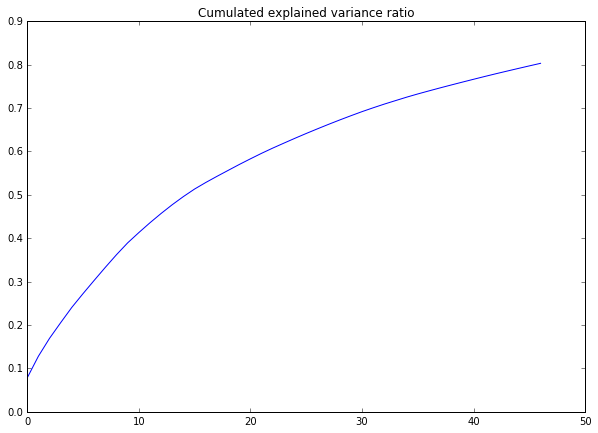

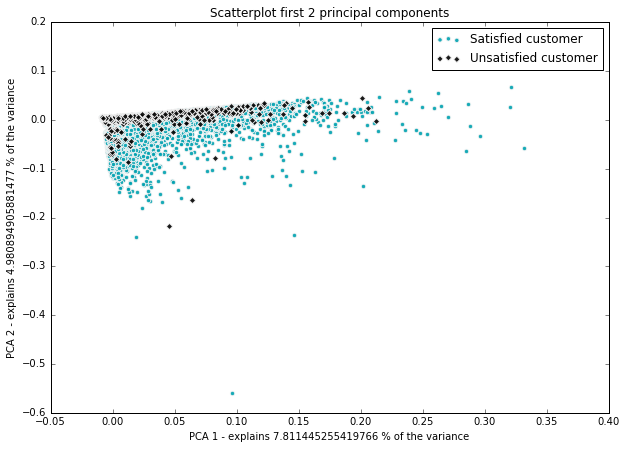

In [6]:
# plot cummulated explained variance ratio
fig = plt.figure(figsize=(10,7))
fig.add_subplot(1,1,1)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulated explained variance ratio')

# plot first two pca results 
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
    
classes = np.sort(np.unique(Y_train))
colors= [(0.0, 0.63, 0.69), 'black']
markers = ['o','D']
labels = ['Satisfied customer', 'Unsatisfied customer']
    
for class_ix, marker, color, label in zip(classes, markers, colors, labels):
    ax.scatter(X_train_projected[np.where(Y_train == class_ix), 0],
            X_train_projected[np.where(Y_train == class_ix), 1],
            marker = marker, color=color, edgecolor='whitesmoke', 
            linewidth='1', alpha=0.9, label = label)
    ax.legend(loc='best')
        
plt.title('Scatterplot first 2 principal components')
plt.xlabel('PCA 1 - explains {} % of the variance'.format(pca.explained_variance_ratio_[0] * 100.00))
plt.ylabel('PCA 2 - explains {} % of the variance'.format(pca.explained_variance_ratio_[1] * 100.00))
plt.show()

## Train model: Random forest on PCA data

In [7]:
from sklearn.ensemble import RandomForestClassifier

In [8]:
Y_train.shape

(60816,)

In [9]:
clf = RandomForestClassifier(n_estimators=10)

# TRAIN
clf.fit(X_train_projected, Y_train) 

# PREDICT       
pred_labels = clf.predict(X_valid_projected)
pred_proba = clf.predict_proba(X_valid_projected)[:,1]

# EVALUATE
pred_score = clf.score(X_valid_projected, Y_valid)
print('... prediction score: {0:0.2f}%'.format(pred_score * 100))

... prediction score: 94.88%


## Confusion matrix on trained model

In [24]:
from sklearn.metrics import confusion_matrix

In [18]:
print(confusion_matrix(Y_valid, pred_labels))

[[14513    89]
 [  592    10]]


## ROC / AUC on trained model 

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

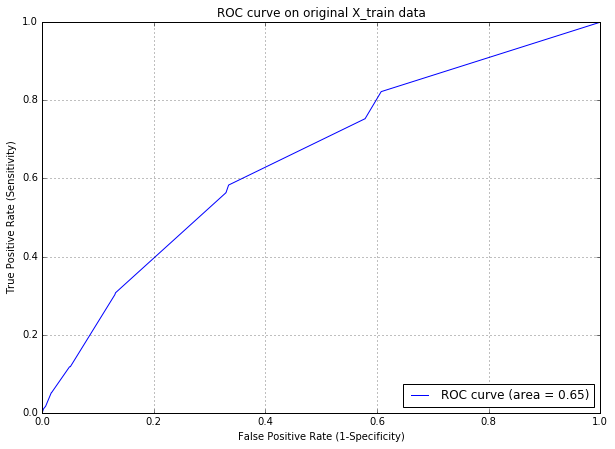

In [21]:
# calculate the false positive and true positive rates. 
# calculate the auc score

fpr, tpr, thresholds = roc_curve(Y_valid, pred_proba)
auc_score = roc_auc_score(Y_valid, pred_proba) 


# plot the roc curve
fig = plt.figure(figsize=(10,7))
fig.add_subplot(1,1,1)    
    
plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'.format(auc_score))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve on original X_train data')
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.legend(loc='lower right')
print('')